In [46]:
import os, glob
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class ClothesTrousersDataset(Dataset):
    def __init__(self, root_dir, image_size=224):
        self.class_names = ['clothes', 'trousers']
        self.files, self.labels = [], []

        for idx, cls in enumerate(self.class_names):
            pattern = os.path.join(root_dir, cls, '*')
            imgs = glob.glob(f"{pattern}.jpg") + glob.glob(f"{pattern}.png")
            self.files += imgs
            self.labels += [idx] * len(imgs)

        assert len(self.files) > 0, f"Tidak ada gambar di {root_dir}"
        print(f"> Loaded {len(self.files)} images from {root_dir}")

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert('RGB')
        return self.transform(img), self.labels[idx]


In [47]:
train_ds = ClothesTrousersDataset('/kaggle/input/clothesandtrousers/dataset/train')
test_ds  = ClothesTrousersDataset('/kaggle/input/clothesandtrousers/dataset/test')


> Loaded 200 images from /kaggle/input/clothesandtrousers/dataset/train
> Loaded 2 images from /kaggle/input/clothesandtrousers/dataset/test


In [48]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_ds.class_names))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [49]:
num_epochs = 5

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0
    for imgs, lbls in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        loss = criterion(model(imgs), lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    print(f"Train Loss: {total_loss/len(train_ds):.4f}")

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == lbls).sum().item()
            total += lbls.size(0)
    print(f"Test Accuracy: {correct/total*100:.2f}%\n")


Epoch 1/5: 100%|██████████| 7/7 [00:25<00:00,  3.59s/it]

Train Loss: 0.2448


Test Accuracy: 100.00%



Epoch 2/5: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]

Train Loss: 0.0139


Test Accuracy: 100.00%



Epoch 3/5: 100%|██████████| 7/7 [00:25<00:00,  3.64s/it]

Train Loss: 0.0020


Test Accuracy: 100.00%



Epoch 4/5: 100%|██████████| 7/7 [00:25<00:00,  3.65s/it]

Train Loss: 0.0015


Test Accuracy: 100.00%



Epoch 5/5: 100%|██████████| 7/7 [00:24<00:00,  3.52s/it]

Train Loss: 0.0034


Test Accuracy: 100.00%



In [50]:
import matplotlib.pyplot as plt

def predict_single(img_path):
    img = Image.open(img_path).convert('RGB')
    tf = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    t = tf(img).unsqueeze(0).to(device)
    model.eval()
    pred = model(t).argmax(dim=1).item()
    label = train_ds.class_names[pred]
    plt.imshow(img); plt.axis('off'); plt.title(label); plt.show()
    print("Predicted:", label)


In [51]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_single(img_path, model, class_names, device):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],
                             [0.229,0.224,0.225])
    ])
    img_t = transform(img).unsqueeze(0).to(device)  # tambahkan dim batch
    with torch.no_grad():
        outputs = model(img_t)
        pred = outputs.argmax(dim=1).item()
    label = class_names[pred]
    plt.imshow(img); plt.axis('off')
    plt.title(f"Predicted: {label}")
    plt.show()
    print("Predicted:", label)


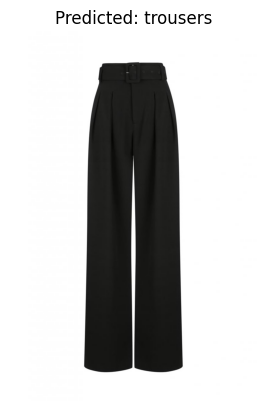

Predicted: trousers


In [54]:
# Class names sama seperti di dataset dan model
class_names = train_ds.class_names  # ['clothes', 'trousers']

# Panggil fungsi predict_single
predict_single(
    '/kaggle/input/clothesandtrousers/dataset/test/trousers/Belinda Pant Black.jpg',
    model,
    class_names,
    device
)
